# Exploratory Analysis of Product and Client Data

There are 1,799 unique product ids and 880,604 unique client ids in the Grupo Bimbo data set. Product ID (Producto_ID), Product Name (NombreProducto), Client Id (Cliente_ID), and Client Name (NombreCliente) are all high cardinality features. This is an exploration intended to discover what additional information can be obtained from these variables.

## Important Necessary Packages 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
%matplotlib inline

## Load the data

Please be patient. The train dataset is over 3GB so this could take a few minutes to load...

In [3]:
os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')  
products = pd.read_csv('producto_tabla.csv', sep = ",")
clients = pd.read_csv('cliente_tabla.csv', sep = ",")
train = pd.read_csv('train.csv', sep = ",")
train.head()
columns = ['Producto_ID', 'Cliente_ID', 'Agencia_ID', 'Demanda_uni_equil']
train = train.ix[:, columns]
train.head()

,Producto_ID,Cliente_ID,Agencia_ID,Demanda_uni_equil
0,1212,15766,1110,3
1,1216,15766,1110,4
2,1238,15766,1110,4
3,1240,15766,1110,4
4,1242,15766,1110,3


## Examine product data

In [4]:
print 'Shape: ' + str(products.shape)
products.head()
print '# Duplicate Values: '+ str(products.duplicated(keep = False).sum())
products.head()

Shape: (2592, 2)
# Duplicate Values: 0


,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


I did not notice the clear pattern in the NombreProducto column at first. There is definitely a (Product Name, Pieces, Weight, Brand) pattern in the data as pointed out by this Kaggle user: https://www.kaggle.com/vykhand/grupo-bimbo-inventory-demand/exploring-products The credit for the invention of these features belongs to them. 

## Split NombreProducto into 4 new features

In [5]:
products['short_product_name'] = products['NombreProducto'].str.extract('^(\D*)', expand = False)
products['pieces'] = products['NombreProducto'].str.extract('(\d+)p ', expand = False).astype(float)
weights = products['NombreProducto'].str.extract('(\d+)(Kg|g)', expand = True)
products['weight'] = weights[0].astype('float') * weights[1].map({'Kg': 1000, 'g': 1})
products['brand'] = products['NombreProducto'].str.extract('^.+\s(\D+) \d+$')
products.head()

C:\Users\thep3\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,Producto_ID,NombreProducto,short_product_name,pieces,weight,brand
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,NaN,NaN,IDENTIFICADO
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NaN,750.0,NES
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,6.0,480.0,BIM
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,NaN,170.0,LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,4.0,45.0,TR


Clean up the short_product_name feature by removing stopwords and stem words...

In [6]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("spanish")

# Remove stopwords
products['short_product_name'] = (products['short_product_name'].map(lambda x: " ".join([i for i in x.lower()
                                                            .split() if i not in stopwords.words("spanish")])))

# Remove stemwords
products['short_product_name'] = (products['short_product_name'].map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))

products.head()

,Producto_ID,NombreProducto,short_product_name,pieces,weight,brand
0,0,NO IDENTIFICADO 0,identific,NaN,NaN,IDENTIFICADO
1,9,Capuccino Moka 750g NES 9,capuccin mok,NaN,750.0,NES
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,bimboll ext sajonjoli,6.0,480.0,BIM
3,53,Burritos Sincro 170g CU LON 53,burrit sincr,NaN,170.0,LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,div tir mini doradit,4.0,45.0,TR


## Merge the train and products dataframes

This could take a while...

In [7]:
print 'Shape Before Merge: ' + str(train.shape)
train = train.ix[:, columns].merge(products, on = ['Producto_ID'], how = 'left')
print 'Shape After Merge: ' + str(train.shape)
train.head()

Shape Before Merge: (74180464, 4)
Shape After Merge: (74180464, 9)


,Producto_ID,Cliente_ID,Agencia_ID,Demanda_uni_equil,NombreProducto,short_product_name,pieces,weight,brand
0,1212,15766,1110,3,Roles Canela 2p 120g BIM 1212,rol canel,2.0,120.0,BIM
1,1216,15766,1110,4,Roles Glass 2p 135g BIM 1216,rol glass,2.0,135.0,BIM
2,1238,15766,1110,4,Panquecito Gota Choc 2p 140g BIM 1238,panquecit got choc,2.0,140.0,BIM
3,1240,15766,1110,4,Mantecadas Vainilla 4p 125g BIM 1240,mantec vainill,4.0,125.0,BIM
4,1242,15766,1110,3,Donitas Espolvoreadas 6p 105g BIM 1242,donit espolvor,6.0,105.0,BIM


## Visualize data

Let's take a look at the best-selling products by short_product_name...

In [8]:
columns = ['short_product_name', 'Demanda_uni_equil']
best_sellers = pd.DataFrame({'Adjusted_Sales': train.groupby(['short_product_name'])['Demanda_uni_equil'].sum()}).reset_index()

In [9]:
best_sellers = best_sellers.sort_values(by = ['Adjusted_Sales'], ascending = False)
print best_sellers.head(n=10)

print ''
print 'Unique Product Ids: ' + str(len(train['Producto_ID'].unique()))
print 'Unique short product names: ' + str(len(train['short_product_name'].unique()))
print 'Top Seller as Percentage of All Sales: ' + str(100.0 * best_sellers['Adjusted_Sales'][0] / best_sellers['Adjusted_Sales'].sum())

    short_product_name  Adjusted_Sales
367                nit        57606859
274             gansit        26133420
487              reban        26098669
385          pan blanc        21724162
621          tortillin        19591899
406       pan integral        16943395
326     mantec vainill        15967225
28         barrit fres        14918914
205           don azuc        13744940
209     donit espolvor        12867906

Unique Product Ids: 1799
Unique short product names: 687
Top Seller as Percentage of All Sales: 0.0361763796344


By shortening the product name, we've cut down the number of unique product ids by over 60%.

nit is most commonly sold product, accounting for ~0.36% of total sales. Let's see what a 'nit' is with a quick Google search...

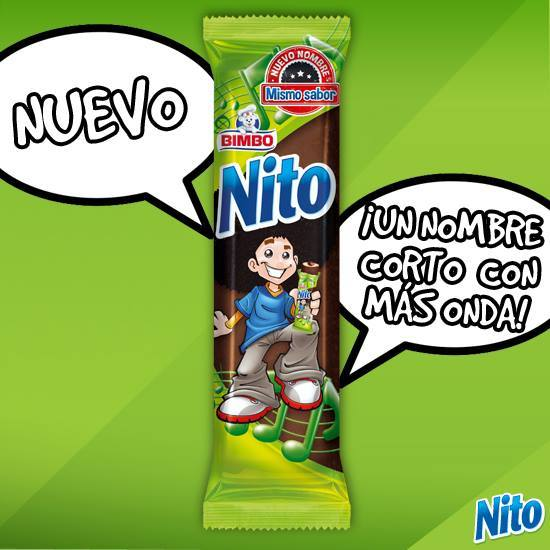

In [10]:
from IPython.display import Image
Image(filename='nito.jpg')

Looks like a tasty chocolate treat! (I actually found one at my local Fred Meyer's and tried it out.)

Let's examine the different variants of the 'nito' product...

In [11]:
columns = ['Producto_ID', 'short_product_name', 'pieces', 'weight', 'brand']
indices = train.ix[train['short_product_name'] == 'nit', :].duplicated(subset = ['Producto_ID', 'short_product_name'], keep = 'first')
indices = indices[indices == False]
train.ix[indices.index, columns].head(n=10)

,Producto_ID,short_product_name,pieces,weight,brand
18,34053,nit,1.0,62.0,BIM
21083,1278,nit,1.0,62.0,BIM
159084,43342,nit,4.0,248.0,BIM
159375,34054,nit,1.0,62.0,BIM
1288104,630,nit,4.0,248.0,BIM
2230749,2425,nit,1.0,62.0,BIM
2338404,43206,nit,1.0,62.0,BIM
3928462,32144,nit,NaN,620.0,BIM
5484853,34055,nit,1.0,62.0,BIM
5484865,46083,nit,4.0,248.0,BIM


Some of these products differ by weight and pieces. Let's dive deeper, and all look at nit products with same pieces and weight.

In [12]:
indices = train.ix[(train['short_product_name'] == 'nit') & (train['pieces'] == 1.0) & (train['weight'] == 62.0), :].duplicated(subset = 
                        ['Producto_ID', 'short_product_name'], keep = 'first')
indices = indices[indices == False]
train.ix[indices.index, columns]

,Producto_ID,short_product_name,pieces,weight,brand
18,34053,nit,1.0,62.0,BIM
21083,1278,nit,1.0,62.0,BIM
159375,34054,nit,1.0,62.0,BIM
2230749,2425,nit,1.0,62.0,BIM
2338404,43206,nit,1.0,62.0,BIM
5484853,34055,nit,1.0,62.0,BIM
7343800,5052,nit,1.0,62.0,BIM
25500945,37159,nit,1.0,62.0,BIM


In [13]:
print 'Unique Product Ids and Names:'
print train.ix[train['short_product_name'] == 'nit', 'Producto_ID'].unique()
print ''
print train.ix[train['short_product_name'] == 'nit', 'NombreProducto'].unique()

Unique Product Ids and Names:
[34053  1278 43342 34054   630  2425 43206 32144 34055 46083  5052 37159]

['Nito 1p 62g SP BIM 34053' 'Nito 1p 62g BIM 1278'
 'Nito ME 4p 248g MTB BIM 43342' 'Nito 1p 62g SP MTB BIM 34054'
 'Nito ME 4p 248g BIM 630' 'Nito 1p 62g Central BIM 2425'
 'Nito 1p 62g MTB BIM 43206' 'Nito 620g Cj MTB BIM 32144'
 'Nito 1p 62g SP TAB BIM 34055' 'Nito ME 4p 248g TAB BIM 46083'
 'Nito 1p 62g Central TAB BIM 5052' 'Nito 1p 62g Central MTB BIM 37159']


## Adding Client data to the Analysis

Let's take a quick look at the data...

In [14]:
print clients.shape

(935362, 2)


In [15]:
clients.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [16]:
# Remove duplicate ids
def remove_duplicate_ids(clients): 
    """ Finds and removes duplicate ids from client data. Returns cleaned data.
    """
    duplicate_ids = clients.duplicated(subset = 'Cliente_ID')    
    clients = clients[duplicate_ids == False]    
    return clients

clients = remove_duplicate_ids(clients)  

In [17]:
clients.shape

(930500, 2)

In [18]:
clients.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


Client ID 0 and 2 have the same client name 'SIN NOMBRE' which translates to 'No Name'.

In [19]:
print '# Unique Cliente_ID: ' + str(len(clients['Cliente_ID'].unique()))
print '# Unique NombreCliente: ' + str(len(clients['NombreCliente'].unique()))

# Unique Cliente_ID: 930500
# Unique NombreCliente: 307009


That's a lot of unique client names. Let's see if we can find similarities and group some of them into similar categories...

Let's look at frequencies of client names...

In [20]:
common_client_names = pd.DataFrame({'Frequency': clients.groupby(['NombreCliente'])['NombreCliente'].count()}).reset_index()
common_client_names['Pct'] = 100.0 * common_client_names['Frequency'] / common_client_names['Frequency'].sum()
common_client_names = common_client_names.sort_values(by = 'Frequency', ascending = False)
common_client_names.head(n=30)

,NombreCliente,Frequency,Pct
227063,NO IDENTIFICADO,281670,30.270822
178995,LUPITA,4863,0.522622
203200,MARY,3016,0.324127
163963,LA PASADITA,2426,0.260720
165834,LA VENTANITA,2267,0.243632
162357,LA GUADALUPANA,1299,0.139602
265099,ROSY,1245,0.133799
20891,ALEX,1242,0.133477
120794,GABY,1238,0.133047
161465,LA ESCONDIDA,1216,0.130682


'NO IDENTIFICADO' (Not Identified) occurs in over 30% of client names. Many of the other common names are colloquial names like Mary, Rosy, Alex, or Gaby. Other client names contain contain stopwords like 'EL' and 'LA' (means 'the' in Spanish). Let's remove these stopwords, and stem words ('TIENDITA' means 'little store').

In [21]:
# Import libraries for handling text data
import re
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stemmer = SnowballStemmer('spanish')

In [22]:
# Create copy of NombreCliente named Client_Type
# Convert to lowercase
clients['Client_Type'] = clients['NombreCliente'].str.lower()
clients.head()

,Cliente_ID,NombreCliente,Client_Type
0,0,SIN NOMBRE,sin nombre
1,1,OXXO XINANTECATL,oxxo xinantecatl
2,2,SIN NOMBRE,sin nombre
3,3,EL MORENO,el moreno
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,sdn ser de alim cuerpo sa cia de int


In [23]:
# Split words in Client_Type variable
nombre_split = clients['Client_Type'].str.split()
    
# Remove empty spaces from names
nombre_no_spaces = [" ".join(x) for x in nombre_split]     
nombre_no_spaces[0:10]

# Remove non-letters and replace numbers
nombre_no_spaces = [re.sub('[^A-Za-z0-9]+', ' ', x) for x in nombre_no_spaces]   
nombre_no_spaces = [re.sub('[0-9]+', 'NUM', x) for x in nombre_no_spaces]
nombre_no_spaces[0:10]

['sin nombre',
 'oxxo xinantecatl',
 'sin nombre',
 'el moreno',
 'sdn ser de alim cuerpo sa cia de int',
 'la vaquita',
 'lupita',
 'i m el guero',
 'mini super los lupes',
 'super kompras micro colon']

In [24]:
# Stem and tokenize words 
nombre_stem = [stemmer.stem(x) for x in nombre_no_spaces]
nombre_tokenized = [word_tokenize(x) for x in nombre_stem]
nombre_tokenized[0:10]

[[u'sin', u'nombr'],
 [u'oxxo', u'xinantecatl'],
 [u'sin', u'nombr'],
 [u'el', u'moren'],
 [u'sdn', u'ser', u'de', u'alim', u'cuerpo', u'sa', u'cia', u'de', u'int'],
 [u'la', u'vaquit'],
 [u'lupit'],
 [u'i', u'm', u'el', u'guer'],
 [u'mini', u'super', u'los', u'lup'],
 [u'super', u'kompras', u'micro', u'colon']]

In [25]:
# Remove stop words
nombre_tokenized = [word_tokenize(x) for x in clients.ix[:, 'Client_Type']]
stops = set(stopwords.words("spanish"))
nombre_cleaned = [[w for w in i if not w in stops] for i in nombre_tokenized] 
nombre_cleaned = [" ".join(x) for x in nombre_cleaned]  
nombre_cleaned[0:30]

['nombre',
 'oxxo xinantecatl',
 'nombre',
 'moreno',
 'sdn ser alim cuerpo sa cia int',
 'vaquita',
 'lupita',
 'i m guero',
 'mini super lupes',
 'super kompras micro colon',
 'lonja mercantil',
 'farmacia nicolas san juan',
 'papeleria catala',
 'elena',
 'casa trino',
 'fma035947 bimbo sa cv',
 'joys',
 'marco',
 'lupes ii',
 'tiendita',
 'fma026712 tecnoautomotriz atlacomulco s',
 'abarrotes ivan',
 'garnica',
 'fma026709 bucirus bladas mexico sa',
 'fma026248 proveedora norte',
 'carrosita',
 'bodega comercial mexicana toluca',
 'marquez',
 'fma033097 automotriz mexicana s c',
 'jose aguilar catalan']

Let's take at some of names that contain the words 'oxxo', 'abarrotes', and 'super'. A quick Google search reveals that 'oxxo' is a chain of convenience stores in Mexico, and 'abarrotes' translates to 'grocery', and 'super' is a word you might see referring to a super-market.

In [26]:
words = ['oxxo', 'abarrotes', 'super']
for word in words: 
    print word + ' : '
    nombre_contains = [(word in x) for x in nombre_cleaned]  
    indices = [n for n, x in enumerate(nombre_contains) if x == True]  
    temp = [nombre_cleaned[i] for i in indices]
    print temp[0:20]    
    print '# Names Appears: ' + str(len(indices))
    print ''

oxxo : 
['oxxo xinantecatl', 'oxxo san carlos', 'oxxo mora', 'oxxo 5 mayo', 'oxxo san sebastian', 'oxxo san javier', 'oxxo carranza', 'oxxo padre mier', 'amoxxo bernardo reyes', 'oxxo tapia', 'oxxo madero terminal', 'oxxo cintermex', 'oxxo pino suarez ii', 'oxxo ruperto martinez', 'oxxo regina', 'oxxo satelite', 'oxxo mederos', 'oxxo condominio', 'oxxo estanzuela 1', 'oxxo prado']
# Names Appears: 9276

abarrotes : 
['abarrotes ivan', 'vinos abarrotes jose', 'abarrotes lupita', 'dulceria abarrotes m t', 'super abarrotes', 'abarrotes profe', 'abarrotes rosario', 'tortilleria abarrotes lourdes', 'abarrotestianguistecanos s c v', 'abarrotes monarca', 'abarrotes ramon ortiz', 'abarrotes chavez', 'abarrotes ballon', 'abarrotes rancho', 'abarrotes elizabeth', 'abarrotes lumbreras', 'abarrotes pesadita', 'abarrotes garza', 'abarrotes licha', 'abarrotes vicky']
# Names Appears: 32871

super : 
['mini super lupes', 'super kompras micro colon', 'super kompras pino suarez', 'super kompras san bue

'oxxo' occurs in 9,276 names, 'abarrotes' in 32,871, and 'super' in 16,736 names. These seem like easy things to group into separate categories. Another Kaggler did a more thorough investigation of client names decided to group all names into one of 16 different categories: 
1. Individual,
2. Oxxo Store
3. Small Franchise
4. Supermarket
5. Hospital/Pharmacy
6. Eatery
7. Bimbo Store
8. General Market/Mart
9. Hotel
10. School
11. Walmart 
12. Govt Store
13. Post 
14. Fresh Market
15. Consignment
16. NO IDENTIFICADO

I thought the analysis was very well done and decided to incorporate this variable into my analysis. All credit for creating this variable goes to the Kaggler who created it: https://www.kaggle.com/abbysobh/grupo-bimbo-inventory-demand/classifying-client-type-using-client-names

I have adapted some of his code for my purposes below:

In [27]:
def create_client_features(clients):
    """ Creates new variable 'Client_Type' by categorizing NombreCliente
    """
    
    # Remove duplicate ids
    clients = remove_duplicate_ids(clients)    
    
    # Create new feature
    clients = clients.copy()
    clients['Client_Type'] = clients.ix[:, 'NombreCliente']    
    
    # Convert to all UPPER-CASE
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.upper()
    
    # Known Large Company / Special Group Types
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.replace('.*REMISION.*','Consignment')
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*WAL MART.*','.*SAMS CLUB.*'],'Walmart', regex=True)
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.replace('.*OXXO.*','Oxxo Store')
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.replace('.*CONASUPO.*','Govt Store')
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.replace('.*BIMBO.*','Bimbo Store')
    
    # Term search for assortment of words picked from looking at their frequencies
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*COLEG.*','.*UNIV.*','.*ESCU.*','.*INSTI.*',\
                                                        '.*PREPAR.*'],'School', regex=True)
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.replace('.*PUESTO.*','Post')
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*FARMA.*','.*HOSPITAL.*','.*CLINI.*'],'Hospital/Pharmacy', regex=True)
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*CAFE.*','.*CREMERIA.*','.*DULCERIA.*',\
                                                        '.*REST.*','.*BURGER.*','.*TACO.*', '.*TORTA.*',\
                                                        '.*TAQUER.*','.*HOT DOG.*',\
                                                        '.*COMEDOR.*', '.*ERIA.*','.*BURGU.*'],'Eatery', regex=True)
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].str.replace('.*SUPER.*','Supermarket')
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*COMERCIAL.*','.*BODEGA.*','.*DEPOSITO.*',\
                                                            '.*ABARROTES.*','.*MERCADO.*','.*CAMBIO.*',\
                                                        '.*MARKET.*','.*MART .*','.*MINI .*',\
                                                        '.*PLAZA.*','.*MISC.*','.*ELEVEN.*','.*EXP.*',\
                                                         '.*SNACK.*', '.*PAPELERIA.*', '.*CARNICERIA.*',\
                                                         '.*LOCAL.*','.*COMODIN.*','.*PROVIDENCIA.*'
                                                        ],'General Market/Mart'\
                                                       , regex=True)                                                   
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*VERDU.*','.*FRUT.*'],'Fresh Market', regex=True)
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace(['.*HOTEL.*','.*MOTEL.*'],'Hotel', regex=True)    
 
    # Filter participles
    clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].replace([
            '.*LA .*','.*EL .*','.*DE .*','.*LOS .*','.*DEL .*','.*Y .*', '.*SAN .*', '.*SANTA .*',\
            '.*AG .*','.*LAS .*','.*MI .*','.*MA .*', '.*II.*', '.*[0-9]+.*'\
                ],'Small Franchise', regex=True)
               
    # Everything else bucketed into 'Individual'
    def filter_remaining(clients):
        def function_word(data):
            # Avoid the single-words created so far by checking for upper-case
            if (data.isupper()) and (data != "NO IDENTIFICADO"): 
                return 'Individual'
            else:
                return data
        clients.ix[:, 'Client_Type'] = clients.ix[:, 'Client_Type'].map(function_word)
    filter_remaining(clients)
    
    # Return data
    return clients

In [28]:
clients = create_client_features(clients)
clients.head()

,Cliente_ID,NombreCliente,Client_Type
0,0,SIN NOMBRE,Individual
1,1,OXXO XINANTECATL,Oxxo Store
2,2,SIN NOMBRE,Individual
3,3,EL MORENO,Small Franchise
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,Small Franchise


Let's look the frequencies of our new categories...

In [29]:
print '# Unique Client_Type: ' + str(len(clients['Client_Type'].unique()))
common_client_types = pd.DataFrame({'Frequency': clients.groupby(['Client_Type'])['Client_Type'].count()}).reset_index()
common_client_types['Pct'] = 100.0 * common_client_types['Frequency'] / common_client_types['Frequency'].sum()
common_client_types = common_client_types.sort_values(by = 'Frequency', ascending = False)
common_client_types

# Unique Client_Type: 16


,Client_Type,Frequency,Pct
8,Individual,351908,37.819237
9,NO IDENTIFICADO,281670,30.270822
13,Small Franchise,158357,17.018485
4,General Market/Mart,65516,7.040946
2,Eatery,30277,3.253842
14,Supermarket,15911,1.709941
10,Oxxo Store,9276,0.996883
6,Hospital/Pharmacy,5693,0.611822
12,School,5562,0.597743
11,Post,2658,0.285653


## Merge Clients with Train

Let's merge client data with train data...

In [30]:
print 'Shape Before Merge: ' + str(train.shape)
train = train.merge(clients, on = 'Cliente_ID', how = 'left')
print 'Shape After Merge: ' + str(train.shape)
train.head()

Shape Before Merge: (74180464, 9)
Shape After Merge: (74180464, 11)


,Producto_ID,Cliente_ID,Agencia_ID,Demanda_uni_equil,NombreProducto,short_product_name,pieces,weight,brand,NombreCliente,Client_Type
0,1212,15766,1110,3,Roles Canela 2p 120g BIM 1212,rol canel,2.0,120.0,BIM,PUESTO DE PERIODICOS LAZARO,Post
1,1216,15766,1110,4,Roles Glass 2p 135g BIM 1216,rol glass,2.0,135.0,BIM,PUESTO DE PERIODICOS LAZARO,Post
2,1238,15766,1110,4,Panquecito Gota Choc 2p 140g BIM 1238,panquecit got choc,2.0,140.0,BIM,PUESTO DE PERIODICOS LAZARO,Post
3,1240,15766,1110,4,Mantecadas Vainilla 4p 125g BIM 1240,mantec vainill,4.0,125.0,BIM,PUESTO DE PERIODICOS LAZARO,Post
4,1242,15766,1110,3,Donitas Espolvoreadas 6p 105g BIM 1242,donit espolvor,6.0,105.0,BIM,PUESTO DE PERIODICOS LAZARO,Post


## Exploratory Data Analysis and Visualization

In [31]:
best_selling_types = pd.DataFrame({'Adjusted Sales': train.groupby(['Client_Type'])['Demanda_uni_equil'].sum()}).reset_index()
best_selling_types['Pct'] = 100.0 * best_selling_types['Adjusted Sales'] / best_selling_types['Adjusted Sales'].sum()
best_selling_types = best_selling_types.sort_values(by = 'Adjusted Sales', ascending = False)
best_selling_types

,Client_Type,Adjusted Sales,Pct
8,Individual,191529780,35.738401
13,Small Franchise,100650079,18.780750
9,NO IDENTIFICADO,82784610,15.447152
4,General Market/Mart,55937875,10.437699
10,Oxxo Store,26720081,4.985820
14,Supermarket,24389983,4.551036
1,Consignment,19691066,3.674244
2,Eatery,14818703,2.765088
15,Walmart,8483857,1.583041
6,Hospital/Pharmacy,4665340,0.870527


Let's visualize sales percentages by client type...

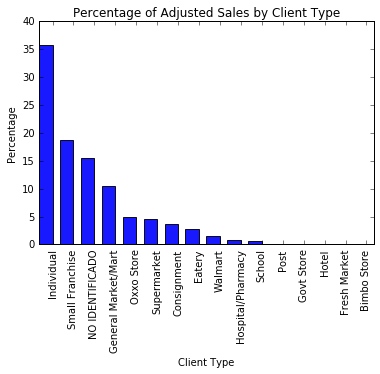

In [32]:
n_groups = len(best_selling_types['Client_Type'])
groups = best_selling_types['Client_Type']
pcts = best_selling_types['Pct']
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.65
opacity = 0.9

rects1 = plt.bar(index, pcts, bar_width,
                 alpha=opacity,
                 color='b')

plt.xlabel('Client Type')
plt.ylabel('Percentage')
plt.title('Percentage of Adjusted Sales by Client Type')
plt.xticks(index + bar_width, groups, rotation = 'vertical')
plt.show()

Let's repeat this, but look at sales of top 2 products.

In [33]:
best_sellers.head(n=2)

,short_product_name,Adjusted_Sales
367,nit,57606859
274,gansit,26133420


In [34]:
products = best_sellers['short_product_name'][0:2]
best_selling_products = pd.DataFrame({'Adjusted Sales': train.ix[train['short_product_name'].isin(products)].groupby(
            ['Client_Type', 'short_product_name'])['Demanda_uni_equil'].sum()}).reset_index()
best_selling_products

,Client_Type,short_product_name,Adjusted Sales
0,Bimbo Store,gansit,6070
1,Bimbo Store,nit,10801
2,Consignment,gansit,1565
3,Consignment,nit,3613
4,Eatery,gansit,642463
5,Eatery,nit,1282035
6,Fresh Market,gansit,28500
7,Fresh Market,nit,75330
8,General Market/Mart,gansit,2294139
9,General Market/Mart,nit,4500594


In [35]:
best_selling_products['Pct'] = 100.0 * best_selling_products['Adjusted Sales']
unique_products = list(best_selling_products['short_product_name'].unique())
for product in unique_products: 
    product_sum = best_sellers.ix[best_sellers['short_product_name'] == product, 'Adjusted_Sales'].sum()
    best_selling_products.ix[best_selling_products['short_product_name'] == product, 'Pct'] /= 1.0 * product_sum
best_selling_products

,Client_Type,short_product_name,Adjusted Sales,Pct
0,Bimbo Store,gansit,6070,0.023227
1,Bimbo Store,nit,10801,0.018750
2,Consignment,gansit,1565,0.005989
3,Consignment,nit,3613,0.006272
4,Eatery,gansit,642463,2.458396
5,Eatery,nit,1282035,2.225490
6,Fresh Market,gansit,28500,0.109056
7,Fresh Market,nit,75330,0.130766
8,General Market/Mart,gansit,2294139,8.778564
9,General Market/Mart,nit,4500594,7.812601


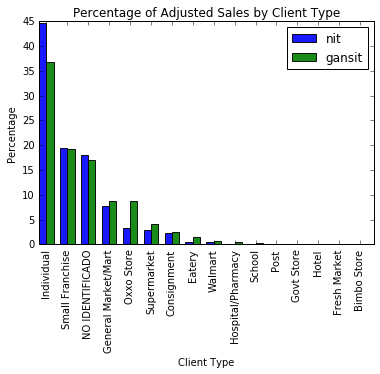

In [36]:
n_groups = len(best_selling_types['Client_Type'])
groups = best_selling_types['Client_Type']

pcts = best_selling_products.ix[best_selling_products['short_product_name'] == 'nit', 'Pct'].sort_values(ascending = False)
pcts2 = best_selling_products.ix[best_selling_products['short_product_name'] == 'gansit', 'Pct'].sort_values(ascending = False)
pcts3 = best_selling_products.ix[best_selling_products['short_product_name'] == 'reban', 'Pct'].sort_values(ascending = False)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.9

rects1 = plt.bar(index, pcts, bar_width,
                 alpha=opacity,
                 color='b',
                 label='nit')

rects2 = plt.bar(index + bar_width, pcts2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='gansit')

plt.xlabel('Client Type')
plt.ylabel('Percentage')
plt.title('Percentage of Adjusted Sales by Client Type')
plt.xticks(index + bar_width, groups, rotation = 'vertical')
plt.legend()

#plt.tight_layout()
plt.show()

We can clearly see that a much higher percentage of the product 'nit' is sold in Individual stores than 'gansit' which is sold much more frequently in Oxxo Stores, Supermarkts, and Eateries.